precipitation_(%)       1.000000
humidity                0.638631
wind_speed              0.443770
cloud_cover             0.267368
season                  0.210372
location                0.091911
weather_type           -0.161578
atmospheric_pressure   -0.177444
temperature            -0.287206
uv_index               -0.291601
visibility_(km)        -0.457444
Name: precipitation_(%), dtype: float64


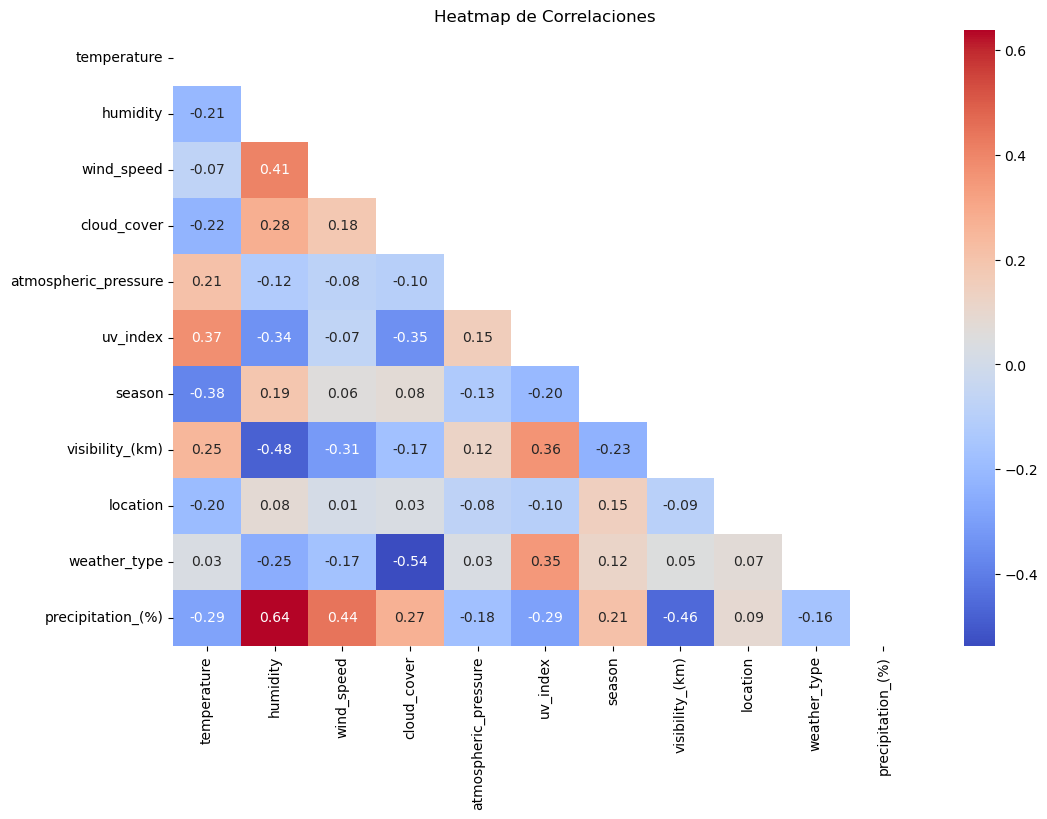

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Cargar los datos
data = pd.read_csv('../data/processed/weather_classification_data.csv')

# Preprocesar los datos
# Codificar variables categóricas
# Opción 1. LabelEncoder -> Hay un orden/jerarquía en la columna categórica (1 er piso, 2º piso, tercer piso)
label_encoder = LabelEncoder() 
categorical_columns = ['cloud_cover', 'season', 'location', 'weather_type']
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])

# Opción 2. Do dummies (no damos peso a las categorías Ej: manzanas verdes, rojas, amarillas)
# data = pd.get_dummies(data, columns=['cloud_cover', 'season', 'location', 'weather_type'])

# Seleccionar variable objetivo
target = 'precipitation_(%)'

# Mostrar la correlación entre las características y el objetivo
correlation = data.corr()
print(correlation[target].sort_values(ascending=False))

# Reorganizar columnas para que la variable objetivo esté al final
columns = [col for col in correlation.columns if col != target] + [target]
correlation = correlation.loc[columns, columns]  # <- orden explícito en filas y columnas

# Volver a crear la máscara después de ordenar
mask = np.triu(np.ones(correlation.shape, dtype=bool))

# Visualizar el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Heatmap de Correlaciones')
plt.show()


In [7]:
# Separar características y etiquetas
X = data.drop(target, axis=1)
y = data[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajustar los parámetros del Random Forest
param_grid = {
    'n_estimators': [15, 20],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Entrenar el modelo con los mejores parámetros
best_params = grid_search.best_params_
rnd_reg = RandomForestRegressor(**best_params)
rnd_reg.fit(X_train_scaled, y_train)

# Predecir
y_pred = rnd_reg.predict(X_test_scaled)

# Evaluar
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

Fitting 5 folds for each of 96 candidates, totalling 480 fits


c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
240 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\jesus\anaconda3\Lib\site-packag

Mean Squared Error: 212.10
R^2 Score: 0.79


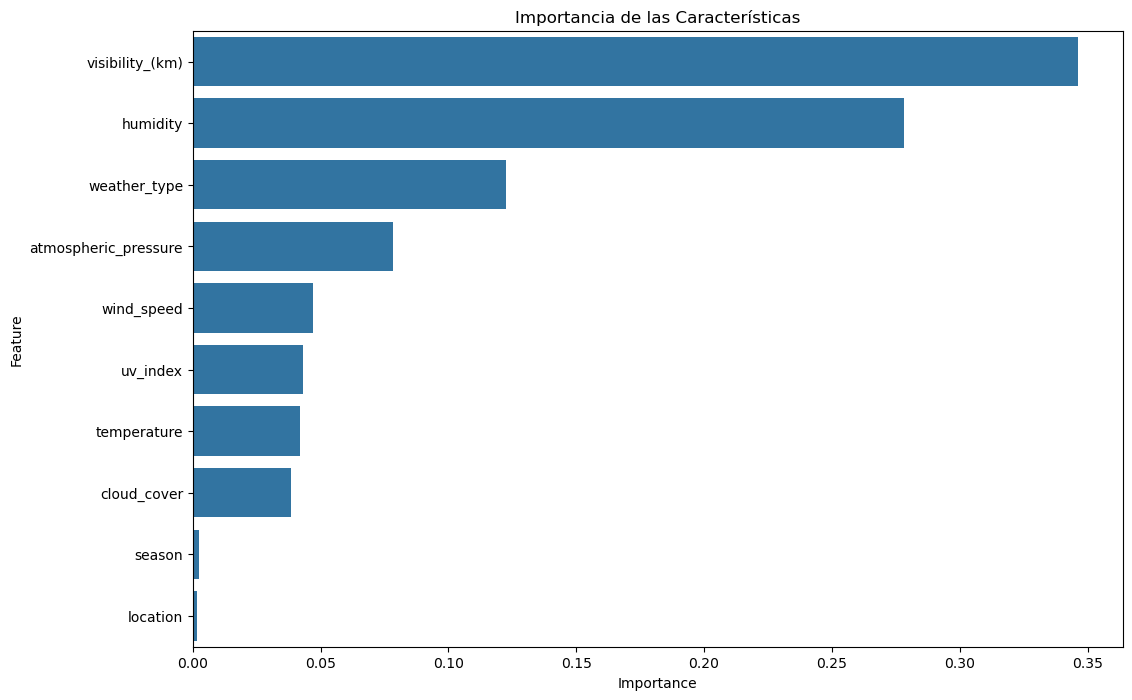

In [8]:
# Importancia de las características
feature_importances = rnd_reg.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las Características')
plt.show()

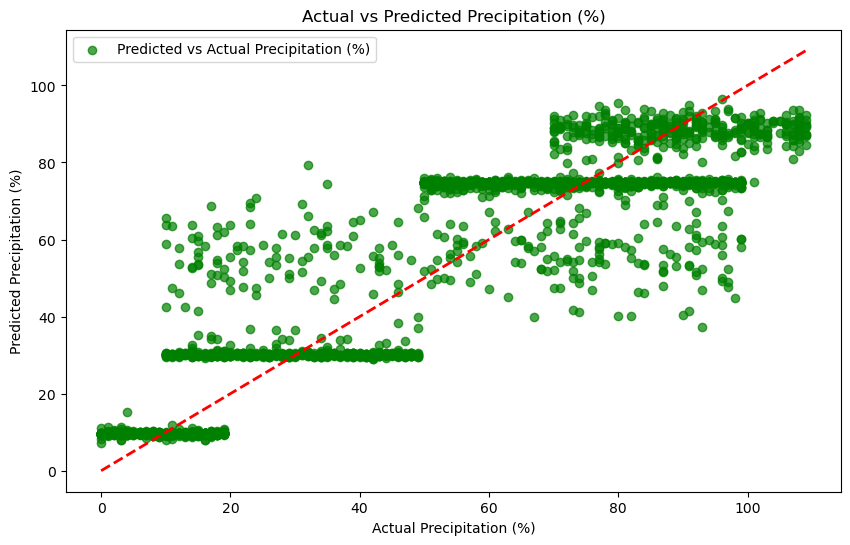

In [9]:
# Visualizar los resultados
plt.figure(figsize=(10, 6))

# Asegurarse de que y_test y y_pred están alineados correctamente
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.7, color='green', label='Predicted vs Actual Precipitation (%)')
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], '--r', linewidth=2)
plt.xlabel('Actual Precipitation (%)')
plt.ylabel('Predicted Precipitation (%)')
plt.title('Actual vs Predicted Precipitation (%)')
plt.legend()
plt.show()

## Predicciones reales de estación meteorológica (con estandarización)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
240 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
174 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\jesus\anaconda3\Lib\site-packag

Mean Squared Error: 217.62
R^2 Score: 0.79


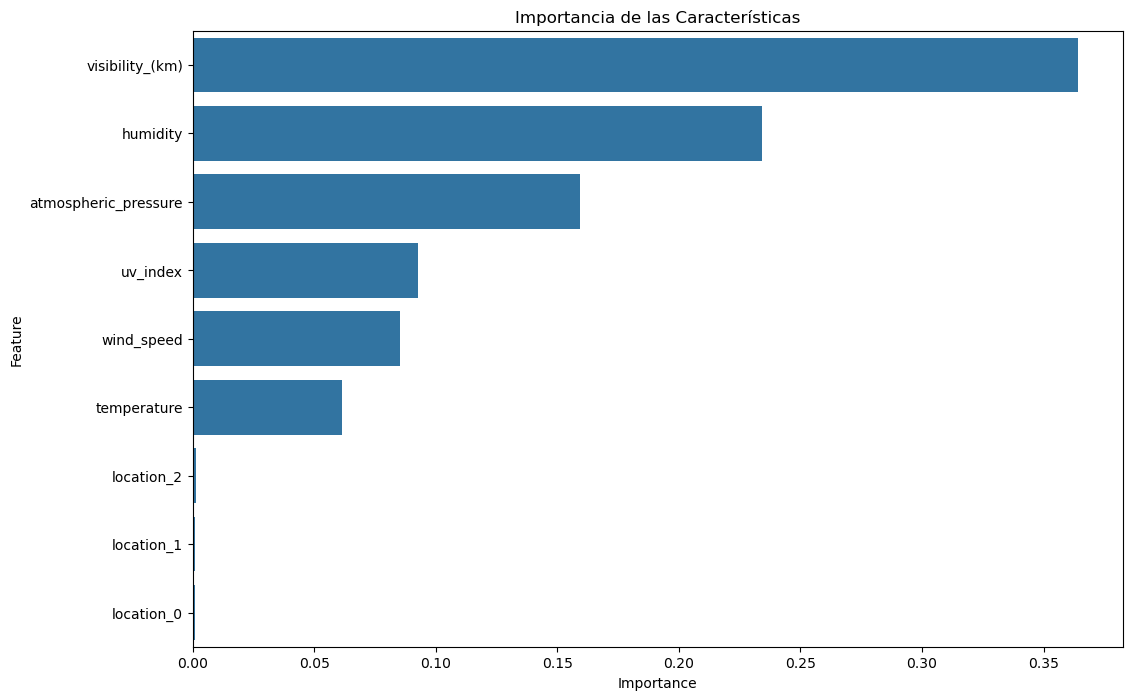

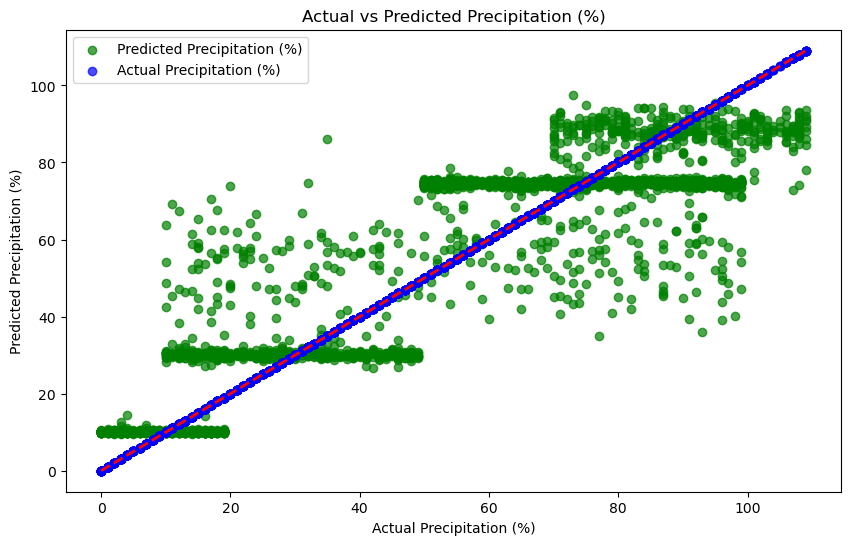

In [10]:
# Drop the 'location' and 'season' columns from data
data_cleaned = data.drop(['weather_type', 'season', 'cloud_cover'], axis=1)

# Do dummies for the 'location' column
data_cleaned = pd.get_dummies(data_cleaned, columns=['location'])

# Do the regressor again
X = data_cleaned.drop(target, axis=1)
y = data_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
rnd_reg = RandomForestRegressor(**best_params)
rnd_reg.fit(X_train_scaled, y_train)

y_pred = rnd_reg.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

feature_importances = rnd_reg.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las Características')
plt.show()

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='green', label='Predicted Precipitation (%)')
plt.scatter(y_test, y_test, alpha=0.7, color='blue', label='Actual Precipitation (%)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Precipitation (%)')
plt.ylabel('Predicted Precipitation (%)')
plt.title('Actual vs Predicted Precipitation (%)')
plt.legend()
plt.show()


## Predicciones reales de estación meteorológica (con Normalización)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
240 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
205 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\jesus\anaconda3\Lib\site-packag

Mean Squared Error: 222.84
R^2 Score: 0.78


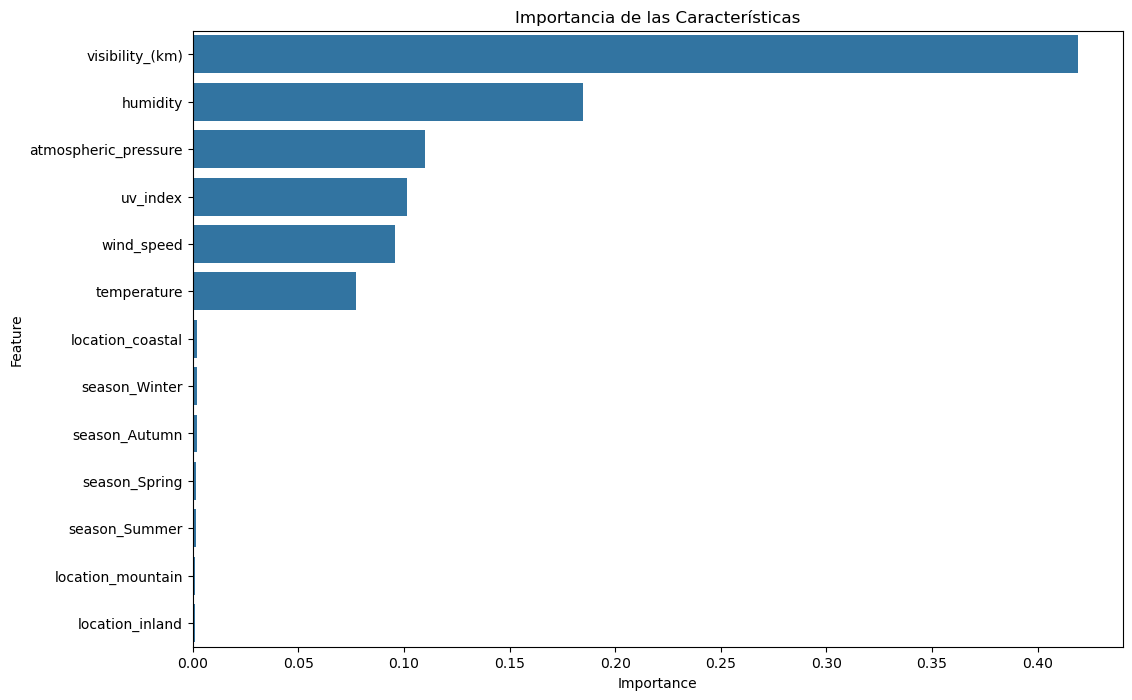

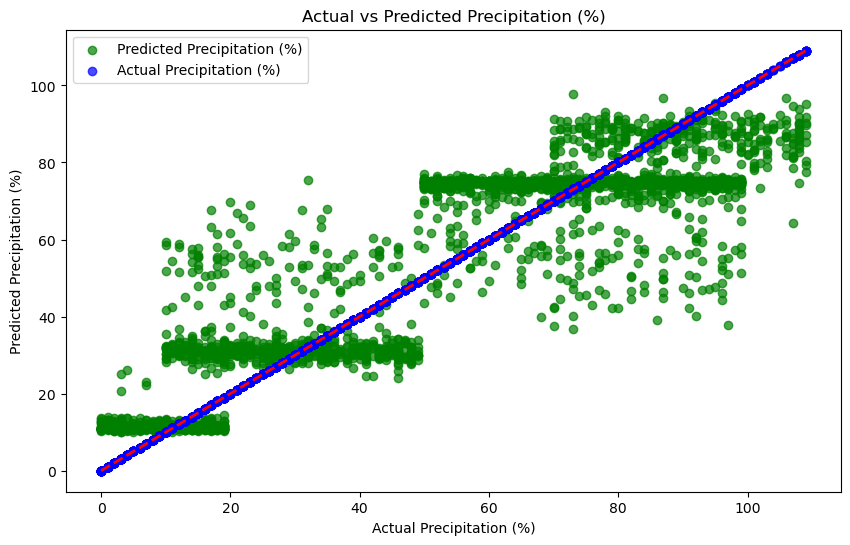

In [11]:
# Load the data
data = pd.read_csv('../data/processed/weather_classification_data.csv')

# Drop the 'weather_type', 'season', 'location', and 'cloud_cover' columns from data
data_cleaned = data.drop(['weather_type', 'cloud_cover'], axis=1)

# Do dummies for the 'location' column
data_cleaned = pd.get_dummies(data_cleaned, columns=['location'])
data_cleaned = pd.get_dummies(data_cleaned, columns=['season'])

# Define the target variable
target = 'precipitation_(%)'

# Split the data into features and target
X = data_cleaned.drop(target, axis=1)
y = data_cleaned[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply MinMaxScaler for normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters from grid search
best_params = grid_search.best_params_

# Train the RandomForestRegressor with the best parameters
rnd_reg = RandomForestRegressor(**best_params)
rnd_reg.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = rnd_reg.predict(X_test_scaled)

# Calculate mean squared error and R^2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

# Get feature importances
feature_importances = rnd_reg.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las Características')
plt.show()

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='green', label='Predicted Precipitation (%)')
plt.scatter(y_test, y_test, alpha=0.7, color='blue', label='Actual Precipitation (%)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Precipitation (%)')
plt.ylabel('Predicted Precipitation (%)')
plt.title('Actual vs Predicted Precipitation (%)')
plt.legend()
plt.show()

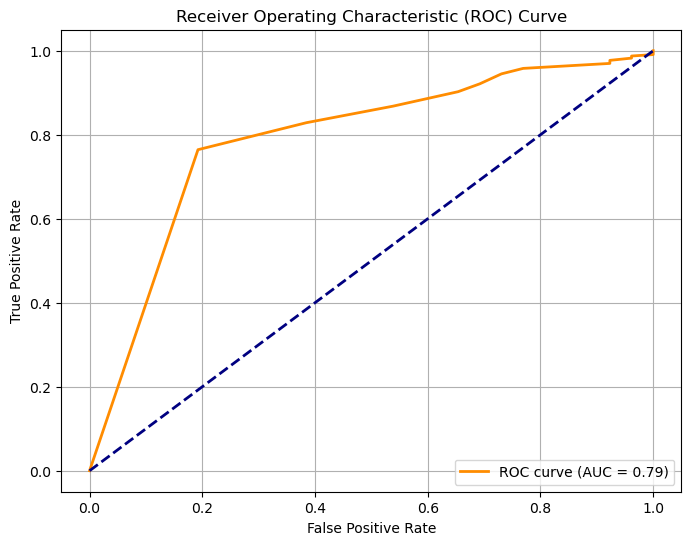

fpr: [0.         0.19230769 0.38461538 0.53846154 0.65384615 0.69230769
 0.73076923 0.76923077 0.92307692 0.92307692 0.96153846 0.96153846
 1.         1.         1.         1.         1.         1.        ]
tpr: [0.         0.76434583 0.82861515 0.86801836 0.90244836 0.92119357
 0.94491201 0.9579189  0.96977812 0.97704667 0.98240245 0.98737567
 0.99081867 0.99387911 0.99540933 0.99770467 0.99846978 1.        ]
thresholds: [ inf 1.   0.99 0.98 0.97 0.96 0.95 0.94 0.93 0.92 0.91 0.9  0.89 0.88
 0.87 0.86 0.85 0.69]


In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Convert regression target to binary classification (e.g., precip > 0 means "precipitation")
y_train_class = (y_train > 0).astype(int)
y_test_class = (y_test > 0).astype(int)

# Entrena un clasificador RandomForest
clf = RandomForestClassifier()
clf.fit(X_train_scaled, y_train_class)

# Predecir probabilidades en el conjunto de prueba
y_probs = clf.predict_proba(X_test_scaled)[:, 1]  # Probabilidad de clase 1 (precipitación)

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test_class, y_probs)
roc_auc = roc_auc_score(y_test_class, y_probs)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# print teh X/Y coordinates of the ROC curve
print(f'fpr: {fpr}')
print(f'tpr: {tpr}')
print(f'thresholds: {thresholds}')


1️⃣ **Uso de One-Hot Encoding en `location`**  
   - Se aplicó `pd.get_dummies(data, columns=['location'])` porque `location` es categórica pero no tiene un orden jerárquico.
   - Esto evita que el modelo interprete una relación incorrecta entre ubicaciones.

2️⃣ **Selección de características basada en datos reales**  
   - Se excluyeron `weather_type`, `season` y `cloud_cover` para hacer que el modelo aprenda únicamente a partir de variables meteorológicas medibles.
   - Esto permite que el modelo sea más útil en escenarios reales donde queremos predecir la lluvia sin depender de etiquetas climáticas.